# PyTorch

[PyTorch](https://pytorch.org/) is an open source machine learning framework for Python, conceptually similar to Keras. PyTorch can be more flexible than Keras for some advanced use cases. PyTorch is often preferred by researchers for this reason.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from matplotlib import pyplot as plt

import numpy as np

In [3]:
torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Learning a Mathematical Function

As an easy to understand example, we will develop a PyTorch model to predict the value of a mathematical function. This example trains quickly, making it ideal for experimentation.

The train and test data sets are generated using the function below. The number of training samples can be adjusted to explore model accuracy as a function of data set size.

In [0]:
def function(x):
    return 10*x**2 - 5*x - 0.5

In [0]:
x_train = np.random.rand(10000).reshape(-1, 1)
y_train = function(x_train).reshape(-1, 1)

x_test = np.linspace(0, 1, 100).reshape(-1, 1)
y_test = function(x_test).reshape(-1, 1)

# Visualize the Dataset

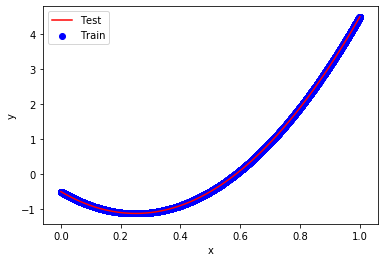

In [6]:
plt.scatter(x_train, y_train, label='Train', color='blue')
plt.plot(x_test, y_test, label='Test', color='red')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')
plt.show()

# Define the Model

A basic, multilayer dense model with [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation functions is used. The output layer does not have activation function in order to produce continous output values.

PyTorch models imperative, meaning the structure of the model defined at run time. In Keras, models are defined ahead of time and then compiled. PyTorch has no compile step.

PyTorch layers are defined in the [torch.nn](https://pytorch.org/docs/stable/nn.html) module.

In [0]:
class Regression(nn.Module):
    def __init__(self):
        super(Regression, self).__init__()
        self.fc1 = nn.Linear(1, 200)
        self.fc2 = nn.Linear(200, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Convert to Tensors

PyTorch has tensors that are very similar to numpy. It is necessary to convert our data set to PyTorch tensors before training and prediction.

Further, PyTorch requires explicit movement from data in a CPU to a GPU and vice-versa.

In [0]:
# CPU tensors for now, they will be loaded into the GPU in batches
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# GPU tensors, no need to validate in batches
x_test_tensor = torch.from_numpy(x_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

# Training

PyTorch training is more explicit than Keras. For example, it is necessary to define a training loop that iterates through the data in batches, as well as computing an initial prediction, losses, back propagation, and validation. The API is easy to use and well documented, so the code below is very common.

In [9]:
model = Regression().to(device)
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

train_data = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=50)

losses = []
val_losses = []
epochs = 10

for epoch in range(epochs):
    model.train()

    batch_losses = []
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        
        loss = criterion(y_batch, y_pred)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        batch_losses.append(loss.item())

    losses.append(np.average(batch_losses))

    with torch.no_grad():
        model.eval()

        yhat = model(x_test_tensor)
        val_loss = criterion(y_test_tensor, yhat)
        val_losses.append(val_loss.item())
    
    print('Loss: %f, validation loss: %f' % (losses[-1], val_losses[-1]))

Loss: 1.170449, validation loss: 0.275553
Loss: 0.140423, validation loss: 0.030888
Loss: 0.018960, validation loss: 0.014292
Loss: 0.009398, validation loss: 0.007665
Loss: 0.004881, validation loss: 0.004000
Loss: 0.002467, validation loss: 0.002114
Loss: 0.001301, validation loss: 0.001139
Loss: 0.000759, validation loss: 0.000700
Loss: 0.000507, validation loss: 0.000482
Loss: 0.000369, validation loss: 0.000360


# Model Loss

The loss is the difference between expected output (y_train) and model output. Lower loss values are better.

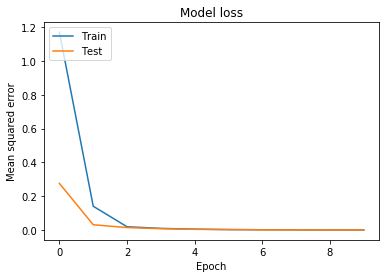

In [10]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('Model loss')
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predictions

In [0]:
y_predictions = model(x_test_tensor).cpu().data.numpy()

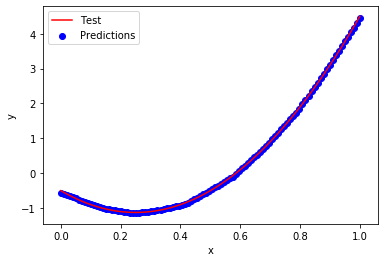

In [12]:
plt.scatter(x_test, y_predictions, label='Predictions', color='blue')
plt.plot(x_test, y_test, label='Test', color='red')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')
plt.show()

# Save the Model

The model parameters (weights and biases) can be save to a file.

In [0]:
torch.save(model.state_dict(), 'parameters.pt')

# Restore Trained Model

In [14]:
restored_model = Regression().to(device)
restored_model.load_state_dict(torch.load('parameters.pt'))
restored_model.eval()

Regression(
  (fc1): Linear(in_features=1, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)

# Predictions

Make predictions using the restored model. It should produce the same results as the original model.

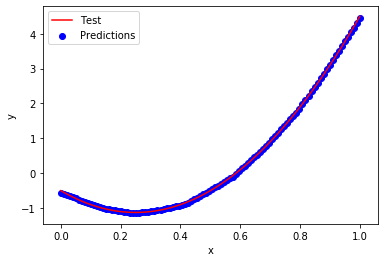

In [15]:
y_predictions = restored_model(x_test_tensor).cpu().data.numpy()

plt.scatter(x_test, y_predictions, label='Predictions', color='blue')
plt.plot(x_test, y_test, label='Test', color='red')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')
plt.show()